In [1]:
import json
from datetime import datetime
import sqlite3
import numpy as np
from typing import List

from math import atan2,degrees


%config InlineBackend.figure_formats = ['svg']
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

import gameBoardDisplay as gbd

from src.gameSimulation.GameUr import GameSettings
from src.store2db import dict_factory

In [2]:
gss: List[GameSettings] = []
with sqlite3.connect("G:/Uni/BA/data/gameHistories_scoreDR_13.db") as con:
    con.row_factory = dict_factory
    c = con.execute('''select * from game where roundcount == 20''')
    fastest = c.fetchone()


    for row in con.execute('''select gameSettingsID, players, dice,
                           prepareLength , fightLength , retreatLength , fightSaveFields ,
                           doubleRollFields , noThrow , exactFinish from gamesettings'''):
        gss.append(GameSettings.fromDB(row))

fastest

{'gameID': 1370881,
 'gameSettingsID': 2,
 'stepcount': 63,
 'roundcount': 20,
 'winners': '["p0"]',
 'stones': '{"p0": {"p0s0": [0, 1, 1, 1, 1, 1, 1, 4, 8, 9, 9, 9, 11, 11, 13, 13, 13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15], "p0s1": [0, 0, 0, 4, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15], "p0s2": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 8, 11, 11, 11, 11, 11, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15], "p0s3": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 8, 11, 1

In [3]:
gss[fastest["gameSettingsID"]]

In [4]:
fastest.keys()
for name in ["winners","stones","roundID","activePlayer","diceRoll", "moveDist", "newRound"]:
    fastest.update({name:json.loads(fastest[name])})

In [5]:
def labelLine(line,align=True,**kwargs):


    ax = line.axes
    xdata = list(line.get_xdata())
    ydata = list(line.get_ydata())

    for i,x2 in enumerate(xdata[1:]):
        moveDist = ydata[i+1]-ydata[i]
        if moveDist == 0:
            continue
        x = (x2+xdata[i])/2
        
        label = str(ydata[i+1]-ydata[i])
        y = (ydata[i+1]+ydata[i])/2


        ip = 1
        for i in range(len(xdata)):
            if x < xdata[i]:
                ip = i
                break

        if align:
            #Compute the slope
            dx = xdata[ip] - xdata[ip-1]
            dy = ydata[ip] - ydata[ip-1]
            ang = degrees(atan2(dy,dx))

            #Transform to screen co-ordinates
            pt = np.array([x,y]).reshape((1,2))
            trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

        else:
            trans_angle = 0

        #Set a bunch of keyword arguments
        if 'color' not in kwargs:
            if moveDist < 0:
                kwargs['color'] = "red"
            else:
                kwargs['color'] = line.get_color()

        if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
            kwargs['ha'] = 'center'

        if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
            kwargs['va'] = 'center'

        if 'backgroundcolor' not in kwargs:
            kwargs['backgroundcolor'] = ax.get_facecolor()

        # if 'clip_on' not in kwargs:
        #     kwargs['clip_on'] = True

        if 'zorder' not in kwargs:
            kwargs['zorder'] = 2.5

        

        ax.text(x,y,label,**kwargs)

In [6]:
def drawGame(currGame,gs:GameSettings, singleGraph=False, showDiceRoll=True, showProgress=True,showDiceRollInline=True):
    stepWidth = 0.2
    stepLineOcc = 0.1

    roundsLabels = [currGame["roundID"][i] if nR else ""  for i,nR in enumerate(currGame["newRound"])]
    globalStepIDs = range(currGame["stepcount"]+1)

    if singleGraph:
        graphcount = 1+showDiceRoll+showProgress
    else:
        graphcount = len(currGame["stones"])+showDiceRoll + showProgress
    
    stepcount = currGame["stepcount"]
    height_ratios = [3]*(graphcount-(showDiceRoll + showProgress)
                         )+[1]*(showDiceRoll + showProgress)

    fig, ax = plt.subplots(nrows=graphcount, sharex=True, figsize=[
        stepWidth*stepcount, 3*graphcount], gridspec_kw={'height_ratios': height_ratios})
    fig.subplots_adjust(hspace=0)


    for a in ax[:-(showDiceRoll + showProgress)]:

        gbd.makeGameboardDisplay( a, *list(gs.getFieldsSettings().values()), xoff=2)
        a.set_yticks(range(0, 16), ["start"]+list(range(1, 15))+["end"])
        for drf in gs.getDoubleRollFields():
            a.axhline(drf, color=(0, 0, 0, 0.3),  ls='--')
    

    for a in ax:
        for i, ap in enumerate(currGame["activePlayer"]):
            if ap == "p0":
                facecolor = '#ff0000'
            elif ap == "p1":
                facecolor = '#00ff00'
            else:
                continue
            a.axvspan(i-0.5, i+0.5, facecolor=facecolor, alpha=stepLineOcc)


    ax[0].set_xlabel('step')
    secax = ax[0].secondary_xaxis('top')
    secax.set_xlabel('round')
    secax.set_xticks(globalStepIDs, roundsLabels,
                        color=(0.1, 0.1, 0.1, 0.8))




    # norm = mpl.colors.Normalize(vmin=min_step_count, vmax=max_step_count)
    stonecount=7
    my_colors = [np.array([np.linspace(.5, 1, stonecount), np.linspace(0, 0, stonecount),
                           np.linspace(0, 0.3, stonecount), np.linspace(0.8, .8, stonecount)]).reshape(4, -1).T,
                 np.array([np.linspace(0, 0, stonecount), np.linspace(0.5, 1, stonecount),
                           np.linspace(0, 0.3, stonecount), np.linspace(0.8, .8, stonecount)]).reshape(4, -1).T]
    

    for i, p in enumerate(currGame["stones"]):
        playerStones = currGame["stones"][p]
        for j,s in enumerate(playerStones):
            if singleGraph:
                axesID = 0
            else:
                axesID = i
            pl = ax[axesID].plot(globalStepIDs,
                    playerStones[s], marker='.', label=s, color=my_colors[i][j])
            if showDiceRollInline:
                labelLine(pl[0],a, color="black",backgroundcolor="#ffffff55",size=8)
            
    
    if showProgress:
        playerProgress = {p: [np.sum([currGame["stones"][p][stone][step]for stone in currGame["stones"][p]])/(15*7)
                            for step in globalStepIDs]for p in currGame["stones"]}
        for p in playerProgress:
            ax[-(showDiceRoll + showProgress)].plot(globalStepIDs, playerProgress[p], label=p)
    
    if showDiceRoll:
        ax[-1].bar(globalStepIDs,
                currGame["diceRoll"],alpha=0.5, label="diceRoll")
        ax[-1].bar(globalStepIDs,
                currGame["moveDist"], alpha=0.5, label="moveDist")

    for a in ax[:-(showDiceRoll + showProgress)]:
        a.axis('equal')
        a.set_xbound(-1, 16)
        a.legend(bbox_to_anchor=(1, 1),
                 loc='upper left', borderaxespad=0.)
    for a in ax:
        # a.grid("y")
        a.set_xbound(-4, stepcount+1)

    if showDiceRoll:
        ax[-1].set_ybound(0,5)
        ax[-1].set_ylim(0,5)
        ax[-1].legend(bbox_to_anchor=(1, 1),
                    loc='upper left', borderaxespad=0.)
    if showProgress:
        ax[-(showDiceRoll + showProgress)].legend(title=" Spielfortschritt", bbox_to_anchor=(1, 1),
                    loc='upper left', borderaxespad=0.)

    # divider = make_axes_locatable(ax[-1])

In [7]:
def drawGameRounds(currGame,gs:GameSettings, singleGraph=False, showDiceRollInline=True):
    stepWidth = 0.2
    stepLineOcc = 0.1

    roundsLabels = [currGame["roundID"][i] if nR else ""  for i,nR in enumerate(currGame["newRound"])]

    graphcount = len(currGame["stones"])
    
    stepcount = currGame["stepcount"]
    height_ratios = [3]*(graphcount)

    fig, ax = plt.subplots(nrows=graphcount, sharex=True,
    figsize=[ stepWidth*stepcount, 3*graphcount],
    gridspec_kw={'height_ratios': height_ratios},
    constrained_layout=True
    )


    for a in ax:

        gbd.makeGameboardDisplay( a, *list(gs.getFieldsSettings().values()), xoff=2)
        a.set_yticks(range(0, 16), ["start"]+list(range(1, 15))+["end"])
        for drf in gs.getDoubleRollFields():
            a.axhline(drf, color=(0, 0, 0, 0.3),  ls='--')
    

    # for a in ax:
    #     for i, ap in enumerate(currGame["activePlayer"]):
    #         if ap == "p0":
    #             facecolor = '#ff0000'
    #         elif ap == "p1":
    #             facecolor = '#00ff00'
    #         else:
    #             continue
    #         a.axvspan(i-0.5, i+0.5, facecolor=facecolor, alpha=stepLineOcc)


    ax[0].set_xlabel('step')
    secax = ax[0].secondary_xaxis('top')
    secax.set_xlabel('round')
    secax.set_xticks(range(currGame["roundcount"]+1),
                        color=(0.1, 0.1, 0.1, 0.8))




    # norm = mpl.colors.Normalize(vmin=min_step_count, vmax=max_step_count)
    stonecount=7
    my_colors = [np.array([np.linspace(.5, 1, stonecount), np.linspace(0, 0, stonecount),
                           np.linspace(0, 0.3, stonecount), np.linspace(0.8, .8, stonecount)]).reshape(4, -1).T,
                 np.array([np.linspace(0, 0, stonecount), np.linspace(0.5, 1, stonecount),
                           np.linspace(0, 0.3, stonecount), np.linspace(0.8, .8, stonecount)]).reshape(4, -1).T]
    

    for i, p in enumerate(currGame["stones"]):
        playerStones = currGame["stones"][p]
        for j,s in enumerate(playerStones):
            if singleGraph:
                axesID = 0
            else:
                axesID = i
            pl = ax[axesID].plot(currGame["roundID"],
                    playerStones[s], marker='.', label=s, color=my_colors[i][j])
            if showDiceRollInline:
                labelLine(pl[0],a, color="black",backgroundcolor="#ffffff55",size=8)
            


    for a in ax:
        a.set_aspect('equal', 'box')
        # a.autoscale()
        a.set_ybound(-1, 16)
        # a.set_xbound(-4, currGame["roundcount"]+1)
        a.legend(bbox_to_anchor=(1, 1),
                 loc='upper left', borderaxespad=0.)
    # for a in ax:
        # a.grid("y")


    # divider = make_axes_locatable(ax[-1])

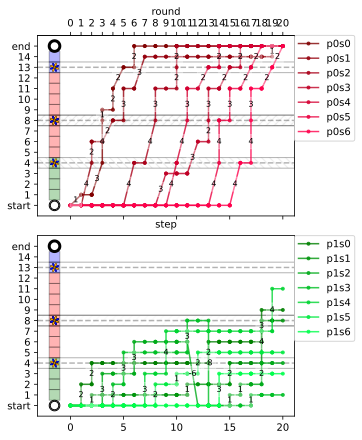

In [8]:
drawGameRounds(fastest,gss[fastest["gameSettingsID"]])